In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from alibi.explainers import CEM
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.11.0
Eager execution enabled:  False


In [2]:
dataset = load_iris()
feature_names = dataset.feature_names
class_names = list(dataset.target_names)

In [3]:
dataset.data = (dataset.data - dataset.data.mean(axis=0)) / dataset.data.std(axis=0)
print(dataset.data.shape)

(150, 4)


In [4]:
x_train, y_train = dataset.data[:145,:], dataset.target[:145]
x_test, y_test = dataset.data[145:,:], dataset.target[145:]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(x_train.shape, x_test.shape)

(145, 4) (5, 4)


In [5]:
def lr_model():#logistic regression
    x_in = Input(shape=(4,))
    x_out = Dense(3, activation='softmax')(x_in)
    lr = Model(inputs=x_in, outputs=x_out)
    lr.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return lr

In [6]:
lr = lr_model()
lr.summary()
lr.fit(x_train, y_train, batch_size=16, epochs=500, verbose=0)
lr.save('iris_lr.h5', save_format='h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [7]:
idx = 0
X=x_test[idx].reshape(1,-1)
print(X.shape)
print(f'Prediction on instance to be explained: {class_names[np.argmax(lr.predict(X))]}')
print(f'Prediction probabilities for each class on the instance: {lr.predict(X)}')

(1, 4)
Prediction on instance to be explained: virginica
Prediction probabilities for each class on the instance: [[1.1210972e-04 6.5574162e-02 9.3431377e-01]]


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [8]:
mode = 'PN' 
shape = X.shape 
print(shape)
kappa = .2 
beta = .1 
c_init = 10.
c_steps = 10 
max_iterations = 1000
feature_range = (x_train.min()-.1, x_train.max()+.1)
clip = (-1000.,1000.)
lr_init = 1e-2 

(1, 4)


In [9]:
 # define model
lr = load_model('iris_lr.h5')
# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,\
max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
learning_rate_init=lr_init, clip=clip)
cem.fit(x_train, no_info_type='median')
explanation = cem.explain(X, verbose=False)

In [10]:
print(explanation.meta.keys())
print(explanation.data.keys())

dict_keys(['name', 'type', 'explanations', 'params', 'version'])
dict_keys(['PN', 'PP', 'PN_pred', 'PP_pred', 'grads_graph', 'grads_num', 'X', 'X_pred'])


In [12]:
print(f'Original instance: {explanation.X}')
print(f'Predicted class: {class_names[explanation.X_pred]}')

Original instance: [[ 1.03800476 -0.13197948  0.8195957   1.44883158]]
Predicted class: virginica


In [13]:
print(f'Pertinent negative: {explanation.PN}')
print(f'Predicted class: {class_names[explanation.PN_pred]}')

Pertinent negative: [[ 1.0380048  -0.13197948 -1.2621917   1.4488316 ]]
Predicted class: versicolor


In [12]:
expl = {}
expl['PN'] = explanation.PN
expl['PN_pred'] = explanation.PN_pred

In [13]:
mode = 'PP'

In [14]:
# define model
lr = load_model('iris_lr.h5')
# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
learning_rate_init=lr_init, clip=clip)
cem.fit(x_train, no_info_type='median')
explanation = cem.explain(X, verbose=False)

In [15]:
print(f'Pertinent positive: {explanation.PP}')
print(f'Predicted class: {class_names[explanation.PP_pred]}')

Pertinent positive: [[8.26795521e-10 1.06415454e-09 2.63217987e-01 1.01295199e+00]]
Predicted class: virginica


In [16]:
expl['PP'] = explanation.PP
expl['PP_pred'] = explanation.PP_pred

In [17]:
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['species'] = np.array([dataset.target_names[i] for i in dataset.target])

In [18]:
pn = pd.DataFrame(expl['PN'], columns=dataset.feature_names)
pn['species'] = 'PN_' + class_names[expl['PN_pred']]
pp = pd.DataFrame(expl['PP'], columns=dataset.feature_names)
pp['species'] = 'PP_' + class_names[expl['PP_pred']]
orig_inst = pd.DataFrame(explanation.X, columns=dataset.feature_names)
orig_inst['species'] = 'orig_' + class_names[explanation.X_pred]
df = df.append([pn, pp, orig_inst], ignore_index=True)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


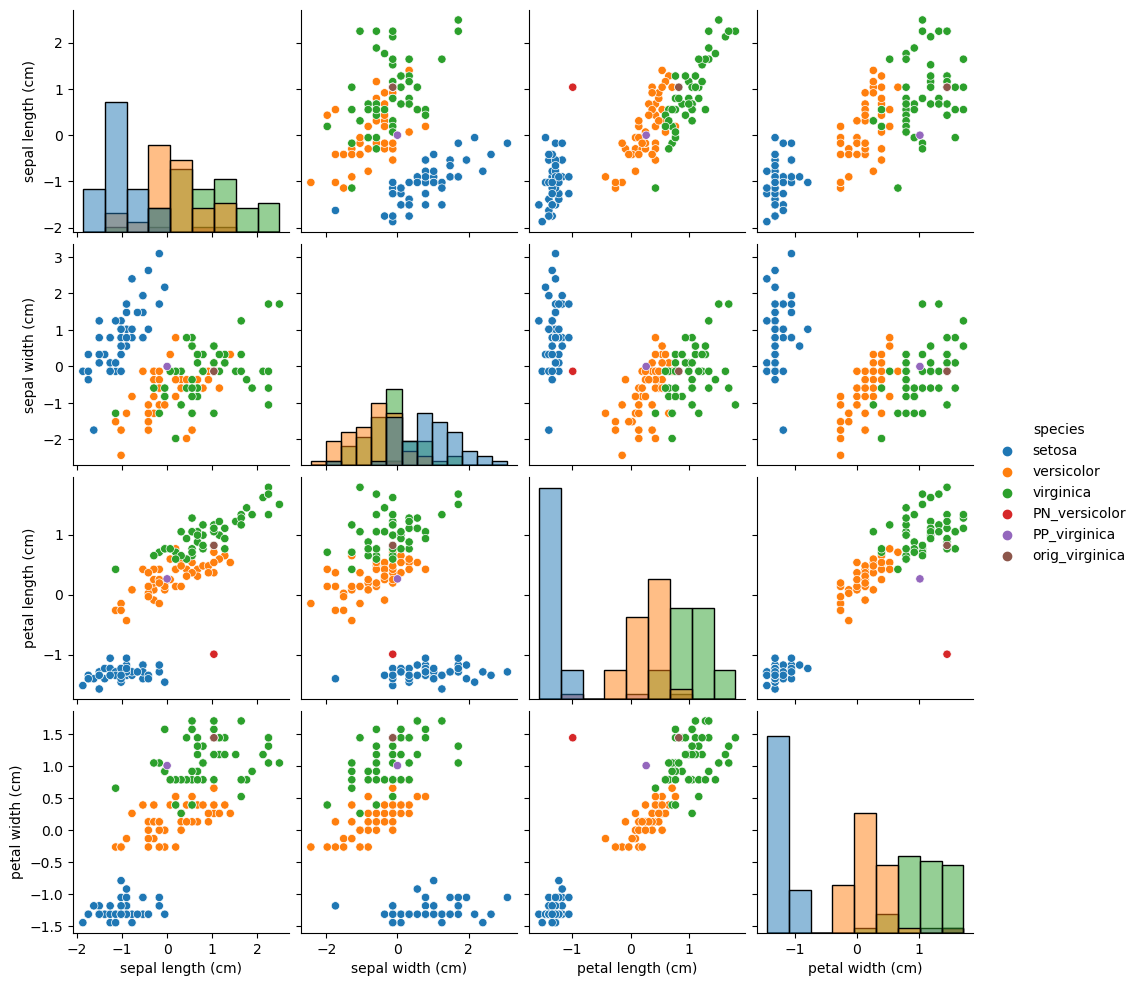

In [19]:
fig = sns.pairplot(df, hue='species', diag_kind='hist');

In [20]:
 mode = 'PN'

In [32]:
eps0 = np.array([[1e-2, 1e-2, 1e-2]]) # 3 prediction categories, equivalent to 1e-2
eps1 = np.array([[1e-2, 1e-2, 1e-2, 1e-2]]) # 4 features, also equivalent to 1e-2
eps = (eps0, eps1)
print(eps)

(array([[0.01, 0.01, 0.01]]), array([[0.01, 0.01, 0.01, 0.01]]))


In [21]:
update_num_grad = 1

In [22]:
# define model
lr = load_model('iris_lr.h5')
predict_fn = lambda x: lr.predict(x) # only pass the predict fn which takes numpy arrays to CEM
cem = CEM(predict_fn, mode, shape, kappa=kappa, beta=beta,
feature_range=feature_range, max_iterations=max_iterations,  
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr_init,clip=clip, update_num_grad=update_num_grad)
cem.fit(x_train, no_info_type='median')
explanation = cem.explain(X, verbose=False)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [23]:
print(f'Original instance: {explanation.X}')
print(f'Predicted class: {class_names[explanation.X_pred]}')

Original instance: [[ 1.03800476 -0.13197948  0.8195957   1.44883158]]
Predicted class: virginica


In [24]:
print(f'Pertinent negative: {explanation.PN}')
print(f'Predicted class: {class_names[explanation.PN_pred]}')

Pertinent negative: [[ 1.0380048  -0.13197948 -0.989557    1.4488316 ]]
Predicted class: versicolor


In [25]:
os.remove('iris_lr.h5')